In [1]:
%matplotlib inline
import numpy as np

# Load training data

In [2]:
import menpo.io as mio
from menpo.landmark import labeller, ibug_face_49, ibug_face_66, ibug_face_66_trimesh

training_images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/trainset/', verbose=True, 
                           max_images=100):
    
    i.crop_to_landmarks_proportion_inplace(1)
    i = i.rescale_landmarks_to_diagonal_range(100)
    labeller(i, 'PTS', ibug_face_49)
    labeller(i, 'PTS', ibug_face_66)
    labeller(i, 'PTS', ibug_face_66_trimesh)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

- Loading 100 assets: [====================] 100%

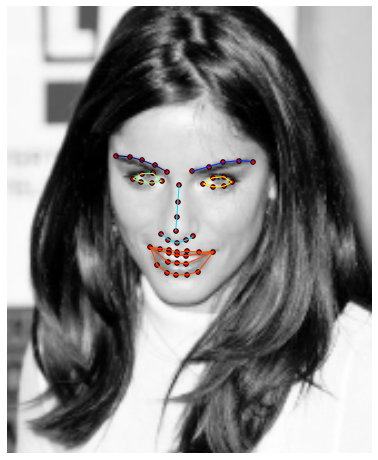

In [3]:
from menpo.visualize import visualize_images

visualize_images(training_images)

# Load test data

In [4]:
import menpo.io as mio
from menpo.landmark import labeller, ibug_face_49, ibug_face_66_trimesh

test_images = []
for i in mio.import_images('/data/PhD/DataBases/faces/afw/', verbose=True, 
                           max_images=10):
    
    i.crop_to_landmarks_proportion_inplace(1)
    i = i.rescale_landmarks_to_diagonal_range(100)
    labeller(i, 'PTS', ibug_face_49)
    labeller(i, 'PTS', ibug_face_66)
    labeller(i, 'PTS', ibug_face_66_trimesh)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

- Loading 10 assets: [====================] 100%

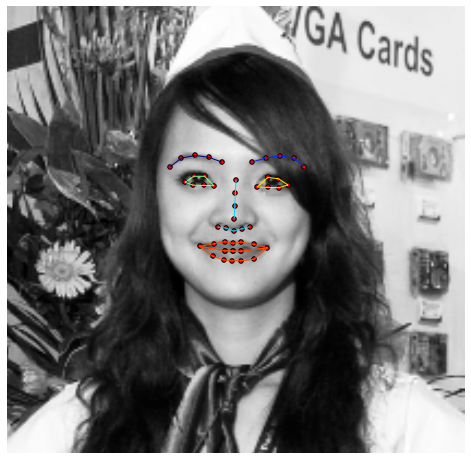

In [5]:
from menpo.visualize import visualize_images

visualize_images(test_images)

# Deep Convolutional Kernels

In [6]:
from alaborticcv2015.deepconvkernel.generative import (
    GenerativeDCKArch1, GenerativeDCKArch2,  GenerativeDCKArch3,
    learn_pca_filters, learn_ica_filters, learn_nmf_filters)
from alaborticcv2015.deepconvkernel.discriminative import (
    DiscriminativeDCKArch1, DiscriminativeDCKArch2,
    learn_lda_filters)
from alaborticcv2015.deepconvkernel.loggabor import (
    LogGaborDCKArch1, LogGaborDCKArch2)


dck = GenerativeDCKArch1(learn_filters=learn_pca_filters, n_filters=8,
                         patch_size=(7, 7), n_levels=5, mean_centre=True,
                         correlation=True,
                         padding='constant', crop=False)
# dck_ = GenerativeDCKArch2(learn_filters=learn_pca_filters, n_filters=4,
#                           patch_size=(7, 7), n_levels=3, mean_centre=True,
#                           padding='constant')

# dck = LogGaborDCKArch1(patch_size=(7, 7), n_levels=3, mean_centre=True,
#                         padding='constant')
# dck_ = LogGaborDCKArch2(patch_size=(7, 7), n_levels=3, mean_centre=True,
#                         padding='constant')

# dck = DiscriminativeDCKArch1(learn_filters=learn_lda_filters, n_filters=8,
#                              patch_size=(7, 7), n_levels=3, mean_centre=True)

ImportError: cannot import name GenerativeDCKArch2

In [29]:
dck.learn_network(training_images, group='ibug_face_66', mean_centre=True, verbose=True)
#dck_.learn_network(training_images, group='ibug_face_66', mean_centre=True, verbose=True)

# dck.learn_network(training_images)
# dck_.learn_network(training_images)

- Learning network: Done!


In [43]:
from menpo.feature import imgfeature

@imgfeature
def deep_kernel_features(img, level=5):
    img = img.copy()
    img.mean_centre_inplace()
    feature = dck.compute_kernel_response(img, level=level)
    feature.landmarks = img.landmarks
    return feature

@imgfeature
def deep_network_features(img, level=5):
    img = img.copy()
    img.mean_centre_inplace()
    feature = dck.compute_network_response(img, level=level)
    feature.landmarks = img.landmarks
    return feature

In [44]:
from menpofit.aam.base import build_reference_frame
from menpo.shape import mean_pointcloud
from menpo.transform import PiecewiseAffine

# build reference frame
shapes = [i.landmarks['PTS'].lms for i in training_images]
mean_shape = mean_pointcloud(shapes)
reference_frame = build_reference_frame(mean_shape)

# warp images
transforms = [PiecewiseAffine(reference_frame.landmarks['source'].lms, s) for s in shapes]
warped_images = [i.warp_to_mask(reference_frame.mask, t) for (i, t) in zip(training_images, transforms)]

img1 = warped_images[1]
img2 = warped_images[2]

In [45]:
from menpo.image import Image

l2 = np.sum((deep_network_features(img1).as_vector() - 
             deep_network_features(img2).as_vector())**2)
print 'deep network L2:', l2

v = deep_network_features(Image(img1.pixels - img2.pixels)).as_vector()
print 'deep network L2:', v.T.dot(v) 

v1 = deep_network_features(Image(img1.pixels)).as_vector()
v2 = deep_network_features(Image(img2.pixels)).as_vector()
print 'deep network dot product:', v1.T.dot(v2)

l2 = np.sum((deep_kernel_features(img1).as_vector() - 
             deep_kernel_features(img2).as_vector())**2)
print 'deep kernel L2:', l2

v = deep_kernel_features(Image(img1.pixels - img2.pixels)).as_vector()
print 'deep kernel L2:', v.T.dot(v) 

v1 = deep_kernel_features(Image(img1.pixels)).as_vector()
v2 = deep_kernel_features(Image(img2.pixels)).as_vector()
print 'deep kernel dot product:', v1.T.dot(v2) 

deep network L2: 147279.922038
deep network L2: 147674.869754
deep network dot product: 2111066.26662
deep kernel L2: 168087.02067
deep kernel L2: 168461.187478
deep kernel dot product: 2495573.24312


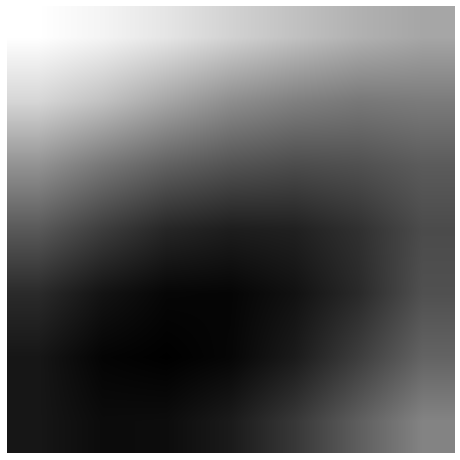

In [46]:
visualize_images(dck.filters[2])

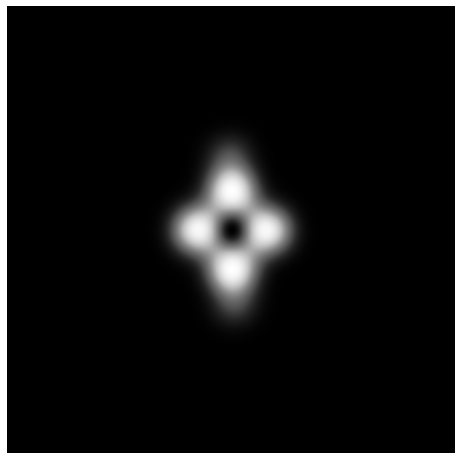

In [47]:
k = Image(np.abs(np.fft.ifftshift(dck.learn_kernel(ext_shape=(200, 200), level=None).pixels)))
k.view_widget()

In [48]:
feature_training_images = [deep_network_features(i, level=None) for i in test_images[:10]] 

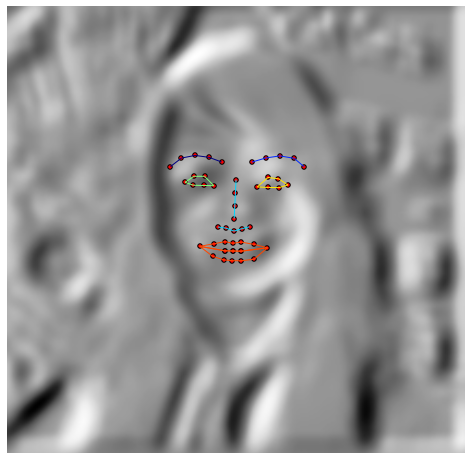

In [49]:
from menpo.visualize import visualize_images

visualize_images(feature_training_images)

In [50]:
feature_training_images = [deep_kernel_features(i, level=None) for i in test_images[:10]] 

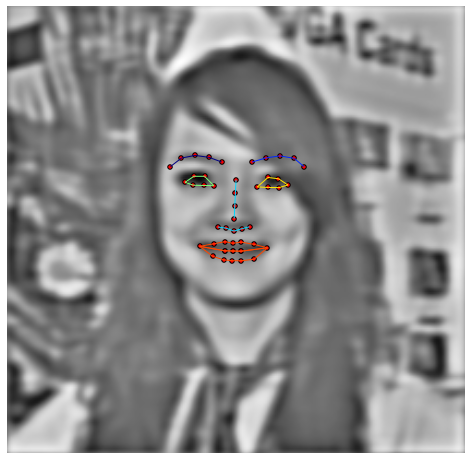

In [51]:
from menpo.visualize import visualize_images

visualize_images(feature_training_images)

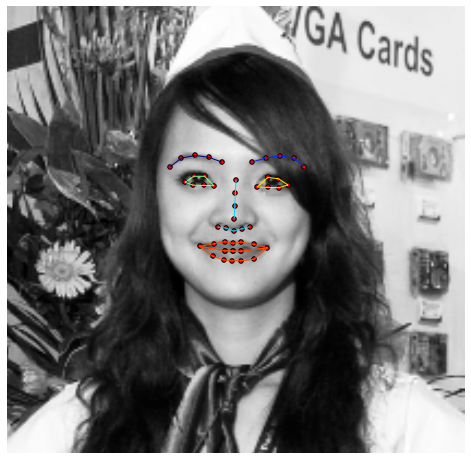

In [52]:
visualize_images(test_images)

# Active Appearance Models

## Global Warp

### Build

In [18]:
from menpo.feature import no_op, fast_dsift
from alabortijcv2015.aam import GlobalAAMBuilder

builder = GlobalAAMBuilder(features=deep_kernel_features, diagonal=100, 
                           #trilist=i.landmarks['ibug_face_66_trimesh'].lms.trilist, 
                           scale_shapes=False, scales=(1, .5))
aam = builder.build(training_images, group='ibug_face_66', verbose=True)

- Building models
  - Level 0: Done
  - Level 1: Done


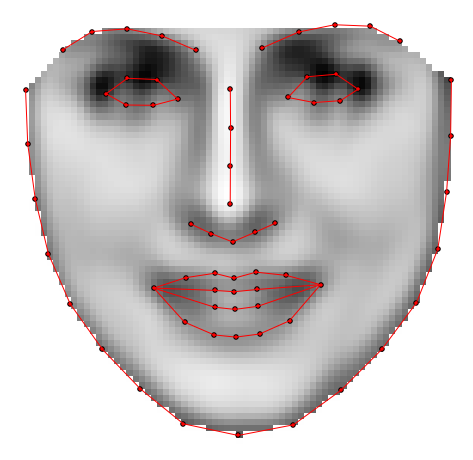

In [19]:
from menpofit.visualize import visualize_appearance_model

visualize_appearance_model(aam.appearance_models[0])

In [20]:
# from menpo.feature import no_op, fast_dsift
# from alabortijcv2015.aam import PartsAAMBuilder

# builder = PartsAAMBuilder(features=deep_pca_conv_features, diagonal=100, 
#                           scale_shapes=False, scales=(1, .5))
# aam = builder.build(training_images, group='ibug_face_66', verbose=True)

### Test

In [21]:
from alabortijcv2015.aam import StandardAAMFitter
from alabortijcv2015.aam.algorithm import SIC, AIC, MAIC
                  
fitter = StandardAAMFitter(aam, algorithm_cls=AIC, n_shape=[3, 6], 
                           n_appearance=[100, 100], sampling_step=4)

In [22]:
# from alabortijcv2015.aam import PartsAAMFitter
# from alabortijcv2015.aam.algorithm import SIC, AIC, MAIC

# sampling_step = 4
# sampling_mask = np.require(np.zeros((17, 17)), dtype=np.bool)
# sampling_mask[::sampling_step, ::sampling_step] = True
                  
# fitter = PartsAAMFitter(aam, algorithm_cls=AIC, n_shape=[3, 12], 
#                         n_appearance=[50, 50], sampling_mask=sampling_mask)

In [23]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images[:10]):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.04)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, map_inference=False)
    fr.downscale = 0.5
    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0636
Final error: 0.0196
Image:  1
Initial error: 0.0955
Final error: 0.0641
Image:  2
Initial error: 0.1467
Final error: 0.1433
Image:  3
Initial error: 0.1086
Final error: 0.0882
Image:  4
Initial error: 0.0723
Final error: 0.0470
Image:  5
Initial error: 0.0723
Final error: 0.0187
Image:  6
Initial error: 0.0613
Final error: 0.0253
Image:  7
Initial error: 0.0566
Final error: 0.0403
Image:  8
Initial error: 0.0775
Final error: 0.0291
Image:  9
Initial error: 0.0946
Final error: 0.1067


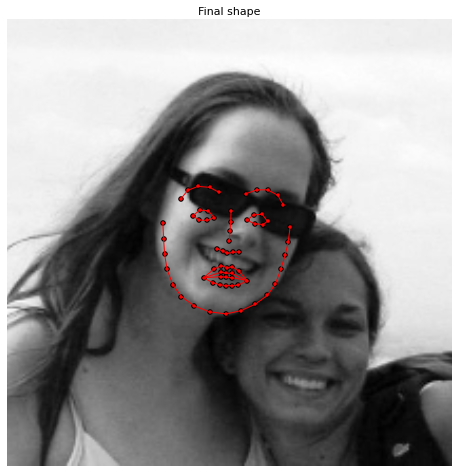

In [25]:
from menpofit.visualize import visualize_fitting_results
    
visualize_fitting_results(fitter_results)